# Testing the Full Model

In [1]:
from scripts.mouse import Mouse

In [ ]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    roc_curve,
    roc_auc_score
)

In [ ]:
# These are the columns used in the final model. We need to ensure that the
# columns in the data we are using to make predictions match these columns.

filtered_columns = [
    'Mouse', 'Session', 'Trial', 'Decision', 'Feedback', 'ACA', 'CA1',
    'CA3', 'CP', 'DG', 'GPe', 'LD', 'LGd', 'LSr', 'MB', 'MOs', 'MRN', 'ORB',
    'PL', 'POST', 'SCm', 'SCs', 'SSp', 'SUB', 'TH', 'TT', 'VISa', 'VISam',
    'VISl', 'VISp', 'VPL', 'VPM', 'ZI', 'root'
]

In [ ]:
# Load in the test data

test_mice = [
    [Mouse(1, test=True)],
    [Mouse(2, test=True)],
]

In [5]:
# Gather model features for all sessions.

global_features = pd.DataFrame()
for mouse in test_mice:
    for session in mouse:
        session.model_features
        session.model_features = session.model_features.reindex(
            columns=global_features.columns.union(session.model_features.columns),
            fill_value=0,
        )
        global_features = pd.concat([global_features, session.model_features])

# Leave the metadata columns alone, but order the brain area columns in
# alphabetical order
metadata = global_features.columns[:5].tolist()
brain_areas = sorted(global_features.columns[5:])
global_features[brain_areas] = global_features[brain_areas].fillna(0)
global_features = global_features[metadata + brain_areas]

In [12]:
global_features.head()

,Mouse,Session,Trial,Decision,Feedback,ACA,ACB,CA3,CP,DG,...,LS,MOs,OT,SI,SNr,SUB,TH,VISp,ZI,root
0,Cori,1,1,4,-1.0,0.899083,0.0,2.220588,0.0,1.794118,...,1.273381,0.893805,0.0,0.0,0.0,2.306667,0.0,1.601124,0.0,0.333333
1,Cori,1,2,3,1.0,0.660550,0.0,2.544118,0.0,2.117647,...,1.237410,0.761062,0.0,0.0,0.0,2.906667,0.0,1.820225,0.0,1.388889
2,Cori,1,3,1,1.0,1.330275,0.0,1.808824,0.0,2.441176,...,1.899281,1.061947,0.0,0.0,0.0,2.666667,0.0,2.370787,0.0,1.444444
3,Cori,1,4,2,1.0,1.477064,0.0,2.411765,0.0,2.558824,...,1.827338,1.053097,0.0,0.0,0.0,2.560000,0.0,1.938202,0.0,1.222222
4,Cori,1,5,1,1.0,0.706422,0.0,2.176471,0.0,2.264706,...,1.115108,0.858407,0.0,0.0,0.0,3.520000,0.0,1.837079,0.0,1.111111


In [16]:
# Ensure filtered_features only has the columns present in filtered_columns
filtered_features = global_features.reindex(columns=filtered_columns, fill_value=0)

# Drop any additional columns that are not in filtered_columns
filtered_features = filtered_features[filtered_columns]

# Remove duplicate columns
filtered_features = filtered_features.loc[:, ~filtered_features.columns.duplicated()]

filtered_features.head()

,Mouse,Session,Trial,Decision,Feedback,ACA,CA1,CA3,CP,DG,...,TH,TT,VISa,VISam,VISl,VISp,VPL,VPM,ZI,root
0,Cori,1,1,4,-1.0,0.899083,0,2.220588,0.0,1.794118,...,0.0,0,0,0,0,1.601124,0,0,0.0,0.333333
1,Cori,1,2,3,1.0,0.660550,0,2.544118,0.0,2.117647,...,0.0,0,0,0,0,1.820225,0,0,0.0,1.388889
2,Cori,1,3,1,1.0,1.330275,0,1.808824,0.0,2.441176,...,0.0,0,0,0,0,2.370787,0,0,0.0,1.444444
3,Cori,1,4,2,1.0,1.477064,0,2.411765,0.0,2.558824,...,0.0,0,0,0,0,1.938202,0,0,0.0,1.222222
4,Cori,1,5,1,1.0,0.706422,0,2.176471,0.0,2.264706,...,0.0,0,0,0,0,1.837079,0,0,0.0,1.111111


In [26]:
# Show the number of null columns in the data:

nonzero_counts = (filtered_features != 0).sum()
nonzero_counts

Mouse                  200
Session                200
Trial                  200
Decision               200
Feedback               200
ACA                    100
CA1                      0
CA3                    200
CP                     100
DG                     100
GPe                      0
LD                       0
LGd                    100
LSr                      0
MB                       0
MOs                    100
MRN                      0
ORB                      0
PL                       0
POST                     0
SCm                      0
SCs                      0
SSp                      0
SUB                    100
TH                     100
TT                       0
VISa                     0
VISam                    0
VISl                     0
VISp                   100
VPL                      0
VPM                      0
ZI                     100
root                   200
Primary_Predictions    200
dtype: int64

In [ ]:
# Load the primary random forest model
random_forest_model = joblib.load('random_forest_model.pkl')

# Prepare the feature columns (excluding the target columns)
feature_cols = [col for col in filtered_features.columns if col not in ["Feedback", "Mouse", "Session", "Trial", "Decision"]]

# Extract the features from the filtered_features dataframe
X_filtered = filtered_features[feature_cols]

# Predict the target using the primary random forest model
filtered_predictions = random_forest_model.predict(X_filtered)

# Add the predictions to the filtered_features dataframe
filtered_features['Predictions'] = filtered_predictions

filtered_features

c:\Users\codyc\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


,Mouse,Session,Trial,Decision,Feedback,ACA,CA1,CA3,CP,DG,...,TT,VISa,VISam,VISl,VISp,VPL,VPM,ZI,root,Primary_Predictions
0,Cori,1,1,4,-1.0,0.899083,0,2.220588,0.000000,1.794118,...,0,0,0,0,1.601124,0,0,0.000000,0.333333,-1.0
1,Cori,1,2,3,1.0,0.660550,0,2.544118,0.000000,2.117647,...,0,0,0,0,1.820225,0,0,0.000000,1.388889,1.0
2,Cori,1,3,1,1.0,1.330275,0,1.808824,0.000000,2.441176,...,0,0,0,0,2.370787,0,0,0.000000,1.444444,1.0
3,Cori,1,4,2,1.0,1.477064,0,2.411765,0.000000,2.558824,...,0,0,0,0,1.938202,0,0,0.000000,1.222222,1.0
4,Cori,1,5,1,1.0,0.706422,0,2.176471,0.000000,2.264706,...,0,0,0,0,1.837079,0,0,0.000000,1.111111,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Lederberg,2,96,3,1.0,0.000000,0,0.800000,0.632911,0.000000,...,0,0,0,0,0.000000,0,0,1.062857,1.757576,1.0
96,Lederberg,2,97,1,1.0,0.000000,0,1.171429,0.607595,0.000000,...,0,0,0,0,0.000000,0,0,1.457143,2.131313,1.0
97,Lederberg,2,98,2,1.0,0.000000,0,2.428571,0.588608,0.000000,...,0,0,0,0,0.000000,0,0,0.680000,1.919192,1.0
98,Lederberg,2,99,1,-1.0,0.000000,0,0.857143,0.481013,0.000000,...,0,0,0,0,0.000000,0,0,0.628571,1.202020,1.0


In [ ]:
filtered_features['Predictions'].value_counts()

Primary_Predictions
 1.0    196
-1.0      4
Name: count, dtype: int64

In [21]:
# Extract the true labels for "Feedback"
true_feedback = filtered_features['Feedback']

# Calculate the accuracy of the model for predicting "Feedback"
feedback_accuracy = accuracy_score(true_feedback, filtered_predictions)

# Print the accuracy
print(f"Accuracy of the model for predicting 'Feedback': {feedback_accuracy:.2f}")

Accuracy of the model for predicting 'Feedback': 0.72


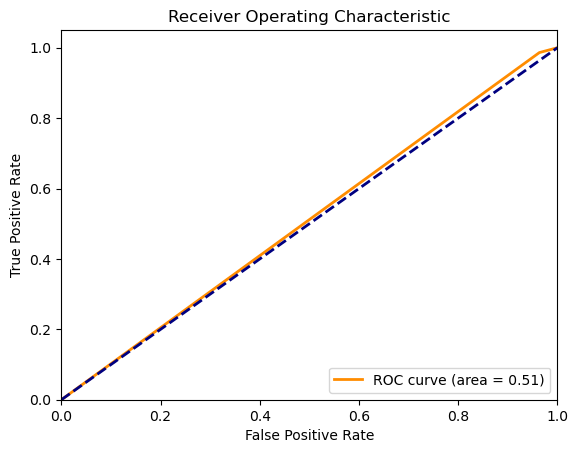

In [25]:
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(true_feedback, filtered_predictions)

# Calculate the AUC (Area Under the Curve)
roc_auc = roc_auc_score(true_feedback, filtered_predictions)

# Plot the ROC curve
plt.figure()
plt.plot(
    fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})'
)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.savefig('./figures/roc_curve.png')
plt.show()

In [ ]:
conf_matrix = confusion_matrix(true_feedback, filtered_predictions)

print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[  2  53]
 [  2 143]]
